<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Setup Library and Import

In [ ]:
!pip install vectorbt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import norm
import plotly.express as px
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 2) Get and Modify Data

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [ ]:
ticker_Binance = "BTCUSDT"
ticker_YFinance = "BTC-USD"
start = "2025-04-7"
end = "2025-04-11"
interval = "5m"

#data_request = vbt.BinanceData.download(ticker_Binance, start= start, end = end, interval = interval)
data_request = vbt.YFData.download(ticker_YFinance, start= start, end = end, interval = interval)
data_v0 = data_request.get()
print("Data size:",data_v0.shape)
print(data_v0.head())

#data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
#plt.plot(data.index,data["Close"])
#plt.show()

Data size: (1152, 7)
                                   Open          High           Low  \
Datetime                                                              
2025-04-07 00:00:00+00:00  78312.203125  78411.726562  78273.507812   
2025-04-07 00:05:00+00:00  77878.679688  78029.468750  77878.679688   
2025-04-07 00:10:00+00:00  77873.078125  77873.078125  77450.367188   
2025-04-07 00:15:00+00:00  77756.328125  77876.250000  77685.906250   
2025-04-07 00:20:00+00:00  77877.132812  77897.929688  77757.054688   

                                  Close      Volume  Dividends  Stock Splits  
Datetime                                                                      
2025-04-07 00:00:00+00:00  78273.507812           0        0.0           0.0  
2025-04-07 00:05:00+00:00  77909.281250   796631040        0.0           0.0  
2025-04-07 00:10:00+00:00  77450.367188           0        0.0           0.0  
2025-04-07 00:15:00+00:00  77869.960938  1211973632        0.0           0.0  
2025-04

In [ ]:
def extend_OHLC_in_data(data):
  input = pd.DataFrame(index = data.index, data = {"Open" :data["Open"],
                                                "High": data["High"],
                                                "Low": data["Low"],
                                                "Close": data["Close"],
                                                "Volume": data["Volume"],
                                                  })

  rows = [{"Datetime": data.index[0],
           "Price": data.loc[data.index[0], "Open"],
           "Volume": data.loc[data.index[0], "Volume"]
           }]
  for t, row in input.iterrows():
    o,h,l,c,v= row["Open"], row["High"], row["Low"], row["Close"], row["Volume"]
    v_row = v/4

    if o>=c:
      values= [h,l,c]
    else:
      values =[l,h,c]

    for value in values:
      rows.append({"Datetime": t,
                  "Price": value,
                  "Volume": v_row})

  input = pd.DataFrame(rows)
  input.set_index("Datetime", inplace=True)
  return input

In [ ]:
data_v1 = extend_OHLC_in_data(data_v0)
print("Data_v0 Shape:",data_v0.shape)
print("Data_v1 Shape:",data_v1.shape)
print(data_v1)

show_plot  = False
if show_plot:
  plt.plot(data_v1["Price"])
  plt.show()

Data_v0 Shape: (1152, 7)
Data_v1 Shape: (3457, 2)
                                  Price       Volume
Datetime                                            
2025-04-07 00:00:00+00:00  78312.203125          0.0
2025-04-07 00:00:00+00:00  78411.726562          0.0
2025-04-07 00:00:00+00:00  78273.507812          0.0
2025-04-07 00:00:00+00:00  78273.507812          0.0
2025-04-07 00:05:00+00:00  77878.679688  199157760.0
...                                 ...          ...
2025-04-10 23:50:00+00:00  79597.914062  188197888.0
2025-04-10 23:50:00+00:00  79597.914062  188197888.0
2025-04-10 23:55:00+00:00  79602.421875          0.0
2025-04-10 23:55:00+00:00  79560.148438          0.0
2025-04-10 23:55:00+00:00  79560.148438          0.0

[3457 rows x 2 columns]


# Get Output

In [ ]:
def normal_pdf_frequencies(n, mean, std, range_std):
    """
    Use the Gaussian PDF to define relative weights for n bins centered around the mean.
    """
    # Define edges in terms of standard deviations
    edges = np.linspace(mean - range_std * std, mean + range_std * std, n + 1)
    midpoints = 0.5 * (edges[:-1] + edges[1:])
    pdf_values = norm.pdf(midpoints, loc=mean, scale=std)
    frequencies = pdf_values / np.sum(pdf_values)
    return frequencies.tolist(), edges

#-------------------------------------------------------------------------------

def verification_output(input,output):
  # Verification
  plt.figure(figsize=(12, 5))

  # Histogramme des future returns
  plt.subplot(1, 2, 1)
  plt.hist(input["Price"].pct_change(look_forward).dropna(), bins=30, color='skyblue', edgecolor='black')
  plt.title("Histogram of Future Returns")
  plt.xlabel("Future Return")
  plt.ylabel("Frequency")

  # Histogramme des catégories gaussiennes
  plt.subplot(1, 2, 2)
  plt.hist(output["Category"].dropna(), bins=np.arange(n+1)-0.5, color='salmon', edgecolor='black', rwidth=0.8)
  plt.xticks(range(n))
  plt.title("Histogram of Gaussian Categories")
  plt.xlabel("Category")
  plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()

#-------------------------------------------------------------------------------

def generate_output_category(input, category_frequencies, look_forward):
    """
    Parameters:
    - input: DataFrame with column "Price"
    - category_frequencies: list of floats (e.g. [0.2, 0.2, 0.2, 0.2, 0.2]) summing to 1
    - look_forward: horizon for future return
    """
    import pandas as pd
    import numpy as np

    output = pd.DataFrame(input["Price"])

    # Step 1: Calculate future returns and rolling stats
    output["Future Return"] = output["Price"].shift(-look_forward) / output["Price"] - 1
    output["Return Mean"] = output["Future Return"].rolling(window=look_forward).mean()
    output["Return Std"] = output["Future Return"].rolling(window=look_forward).std()
    output["Return Z-Score"] = (output["Future Return"] - output["Return Mean"]) / output["Return Std"]

    # Vérification que les fréquences personnalisées sont valides
    category_frequencies = np.array(category_frequencies)
    assert np.isclose(category_frequencies.sum(), 1.0), "Frequencies must sum to 1"

    # Step 2: Compute quantile boundaries from actual distribution
    valid_z = output["Return Z-Score"].dropna()
    cum_freq = np.cumsum(category_frequencies)
    quantile_cutoffs = valid_z.quantile(cum_freq[:-1])  # remove last 1.0
    boundaries = [-np.inf] + list(quantile_cutoffs.values) + [np.inf]

    # Step 3: Categorize Z-scores
    def categorize_zscore(z, bounds):
        if pd.isna(z):
            return np.nan
        for i in range(len(bounds) - 1):
            if bounds[i] <= z < bounds[i + 1]:
                return i

    output["Category"] = output["Return Z-Score"].apply(lambda z: categorize_zscore(z, boundaries))

    # Optional: cleanup
    output.drop(columns=["Price", "Future Return", "Return Mean", "Return Std", "Return Z-Score"], inplace=True)

    return output

                           Category
Datetime                           
2025-04-07 00:00:00+00:00       NaN
2025-04-07 00:00:00+00:00       NaN
2025-04-07 00:00:00+00:00       NaN
2025-04-07 00:00:00+00:00       NaN
2025-04-07 00:05:00+00:00       NaN
2025-04-07 00:05:00+00:00       NaN
2025-04-07 00:05:00+00:00       NaN
2025-04-07 00:10:00+00:00       NaN
2025-04-07 00:10:00+00:00       NaN
2025-04-07 00:10:00+00:00       NaN
2025-04-07 00:15:00+00:00       NaN
2025-04-07 00:15:00+00:00       NaN
2025-04-07 00:15:00+00:00       NaN
2025-04-07 00:20:00+00:00       NaN
2025-04-07 00:20:00+00:00       NaN
2025-04-07 00:20:00+00:00       NaN
2025-04-07 00:25:00+00:00       NaN
2025-04-07 00:25:00+00:00       NaN
2025-04-07 00:25:00+00:00       NaN
2025-04-07 00:30:00+00:00       1.0
2025-04-07 00:30:00+00:00       1.0
2025-04-07 00:30:00+00:00       2.0
2025-04-07 00:35:00+00:00       2.0


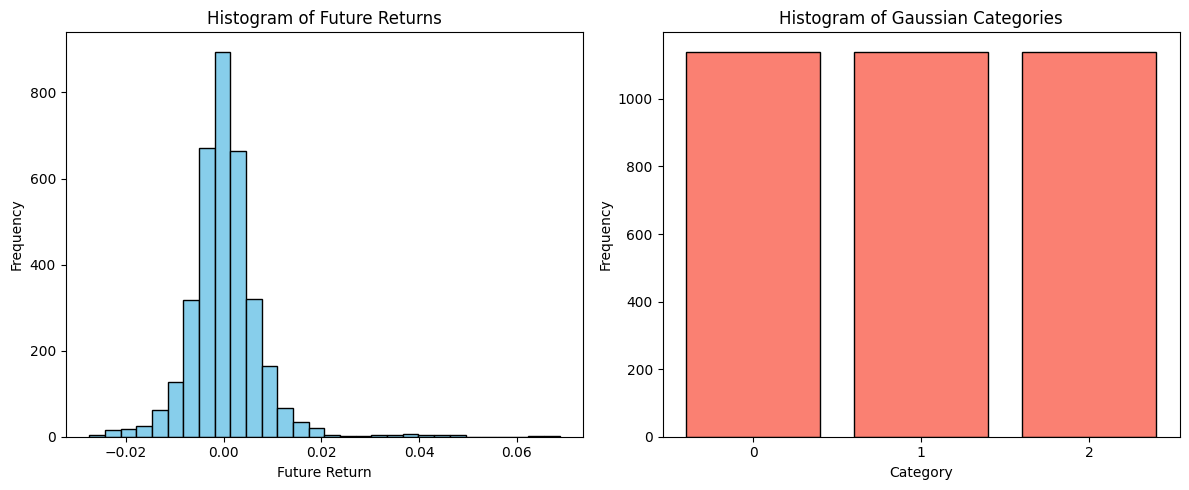

In [ ]:
# Parameters
n = 3  # number of categories
look_forward = 20

data_v1 = extend_OHLC_in_data(data_v0)
input = pd.DataFrame(data_v1["Price"])

output = generate_output_category(input, [1/n]*n, look_forward)

print(output.head(n + look_forward))
verification_output(input,output)

# Generate Train and Test Data

In [ ]:
train_test_data = pd.DataFrame({"Input_1": input["Price"],
                                "Output_1": output["Category"]
                                }).dropna()
print("Train/Test Size:", len(train_test_data))
print(train_test_data.head())

Train/Test Size: 3418
                                Input_1  Output_1
Datetime                                         
2025-04-07 00:30:00+00:00  78245.664062       1.0
2025-04-07 00:30:00+00:00  78016.765625       1.0
2025-04-07 00:30:00+00:00  78016.765625       2.0
2025-04-07 00:35:00+00:00  77919.718750       2.0
2025-04-07 00:35:00+00:00  78057.796875       2.0


In [ ]:
# @title
def split_data(train_test_data, lookback, size_test_prct):
    # 1. Séparer features et labels
    features = train_test_data["Input_1"].values.reshape(-1, 1)  # shape (N, 1)
    labels = train_test_data["Output_1"].values.reshape(-1, 1)   # shape (N, 1)

    # 2. Normaliser uniquement les features
    features = (features - features.min()) / (features.max() - features.min())

    # 3. Recomposer les données normalisées + labels
    data_all = np.hstack((features, labels))  # shape (N, 2)

    # 4. Création des séquences
    data = []
    for index in range(len(data_all) - lookback):
        data.append(data_all[index: index + lookback])

    data = np.array(data)

    # 5. Split train / test
    test_set_size = int(np.round(size_test_prct * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :, :-1]     # Toutes les colonnes sauf Output_1
    y_train = data[:train_set_size, -1, -1]      # Dernière valeur de Output_1
    x_test = data[train_set_size:, :, :-1]
    y_test = data[train_set_size:, -1, -1]

    # 6. Conversion en tenseurs PyTorch
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(train_test_data, 20, 0.3)
y_train_series = pd.Series(y_train.cpu().numpy())
frequency = y_train_series.value_counts().sort_index()
print(frequency)

0    787
1    807
2    785
Name: count, dtype: int64


# 3) Setup LSTM Definition

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList()

        # Première couche LSTM
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim[0], batch_first=True))

        # Couches suivantes
        for i in range(1, self.num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_dim[i-1], hidden_dim[i], batch_first=True))

        # Couche linéaire finale
        self.fc = nn.Linear(hidden_dim[-1], output_dim)

    def forward(self, x):
        out = x
        for lstm in self.lstm_layers:
            out, _ = lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Function to Delete Training Data Variables

In [ ]:
# @title
def del_train_data(list):
  for var in list:
    if var in locals():
        del globals()[var]

Function to Initialize Metrics Tracking

In [ ]:
# @title
def metrics_setup():
    criterion = nn.CrossEntropyLoss()

    # Dictionnaires pour stocker les métriques
    hist_criterion = np.zeros(num_epochs)
    hist_acc = np.zeros(num_epochs)
    hist_f1 = np.zeros(num_epochs)
    hist_precision = np.zeros(num_epochs)
    hist_recall = np.zeros(num_epochs)

    return criterion, hist_criterion, hist_acc, hist_f1, hist_precision, hist_recall

Function to Update Model Metrics

In [ ]:
# @title
def update_metrics(y_train_pred, y_train, criterion):
    loss = criterion(y_train_pred, y_train)

    y_pred = torch.argmax(y_train_pred, dim=1)

    y_pred_np = y_pred.detach().cpu().numpy()
    y_true_np = y_train.detach().cpu().numpy()

    acc = accuracy_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted')
    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)


    return loss, acc, f1, precision, recall

# 4) Setup Data Pisplay Definition

Function to Plot Training Metrics Over Epochs

In [ ]:
# @title
def plot_metrics(hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion):
    metrics = [hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion]
    titles = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'CrossEntropy Loss']
    colors = ['blue', 'green', 'orange', 'purple', 'red']
    ylabel = ['Score'] * 4 + ['Loss']

    epochs = range(1, len(hist_acc) + 1)
    fig, axs = plt.subplots(1, 5, figsize=(22, 4))

    for i, ax in enumerate(axs):
        ax.plot(epochs, metrics[i], color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel[i])
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle('Training Metrics per Epoch', fontsize=16, y=1.05)
    plt.show()

Function to Plot Model Predictions Against Actual Data

In [ ]:
# @title
def visualize_classification_results(y_true, y_pred, output_dim, sequence_title="True vs Predicted", max_points=150):
    """
    Affiche :
    - Matrice de confusion (heatmap)
    - Séquence de classes (true vs pred) sur les derniers points
    - Histogramme de distribution des classes

    Compatible avec Google Colab / Jupyter
    """

    # Convertir en NumPy si Tensor
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    # Créer la figure avec 3 sous-graphes côte à côte
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    plt.subplots_adjust(wspace=0.4)

    # -------------------------------
    # 1. MATRICE DE CONFUSION
    cm = confusion_matrix(y_true, y_pred, labels=range(output_dim))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(range(output_dim)),
                yticklabels=list(range(output_dim)),
                ax=axs[0])
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")
    axs[0].set_title("Confusion Matrix")

    # -------------------------------
    # 2. Séquence de classes
    axs[1].plot(y_true[-max_points:], label='True', marker='o')
    axs[1].plot(y_pred[-max_points:], label='Predicted', marker='x', linestyle='--')
    axs[1].set_title(f"{sequence_title} (last {max_points} samples)")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Class")
    axs[1].legend()
    axs[1].grid(True)

    # -------------------------------
    # 3. Histogramme des classes
    true_counts = pd.Series(y_true).value_counts().sort_index().reindex(range(output_dim), fill_value=0)
    pred_counts = pd.Series(y_pred).value_counts().sort_index().reindex(range(output_dim), fill_value=0)

    bar_width = 0.35
    classes = np.arange(output_dim)

    axs[2].bar(classes - bar_width/2, true_counts, width=bar_width, label='True Labels')
    axs[2].bar(classes + bar_width/2, pred_counts, width=bar_width, label='Predicted Labels')
    axs[2].set_xlabel("Class")
    axs[2].set_ylabel("Count")
    axs[2].set_title("Class Distribution")
    axs[2].set_xticks(classes)
    axs[2].legend()
    axs[2].grid(axis='y')

    plt.show()

Function to Display Model Performance Metrics

In [33]:
# @title
def show_final_metrics():
    # Conversion en NumPy
    y_test_np = y_test.detach().cpu().numpy()
    y_pred_np = y_test_pred.detach().cpu().numpy()

    # Métriques test
    acc_test = accuracy_score(y_test_np, y_pred_np)
    f1_test = f1_score(y_test_np, y_pred_np, average='weighted')
    precision_test = precision_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    recall_test = recall_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
    loss_test = criterion(y_test_pred_list, y_test).item()

    # Moyenne des métriques train
    acc_train = np.mean(hist_acc[-int(num_epochs * 0.2):])
    f1_train = np.mean(hist_f1[-int(num_epochs * 0.2):])
    precision_train = np.mean(hist_precision[-int(num_epochs * 0.2):])
    recall_train = np.mean(hist_recall[-int(num_epochs * 0.2):])
    loss_train = np.mean(hist_criterion[-int(num_epochs * 0.2):])

    # Tableau final
    metrics_data = {
        'Train': [acc_train, f1_train, precision_train, recall_train, loss_train],
        'Test':  [acc_test, f1_test, precision_test, recall_test, loss_test]
    }

    metrics_df = pd.DataFrame(metrics_data, index=['Accuracy', 'F1-score', 'Precision', 'Recall', 'Loss'])

    print("\n📊 Résumé des métriques de classification :\n")
    print(metrics_df.round(4))

# 5) Train, Test and Plot LSTM Model

à rajouter:
- input : 3 dims valeur (0 ou 1) pour les 3 marché NY,London et HK
- input : 4 dims 2 high, 2 low

régulateur pour la perf:
- ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
- torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
- nn.Dropout(p=0.3)

-----------------------------------------------------------------------
Train/Test Size: 3418
-----------------------------------------------------------------------
                                Input_1  Output_1
Datetime                                         
2025-04-07 00:30:00+00:00  78245.664062       2.0
2025-04-07 00:30:00+00:00  78016.765625       3.0
2025-04-07 00:30:00+00:00  78016.765625       3.0
2025-04-07 00:35:00+00:00  77919.718750       4.0
2025-04-07 00:35:00+00:00  78057.796875       3.0
-----------------------------------------------------------------------
Output_1
0.0    489
1.0    732
2.0    976
3.0    732
4.0    489
Name: count, dtype: int64
-----------------------------------------------------------------------


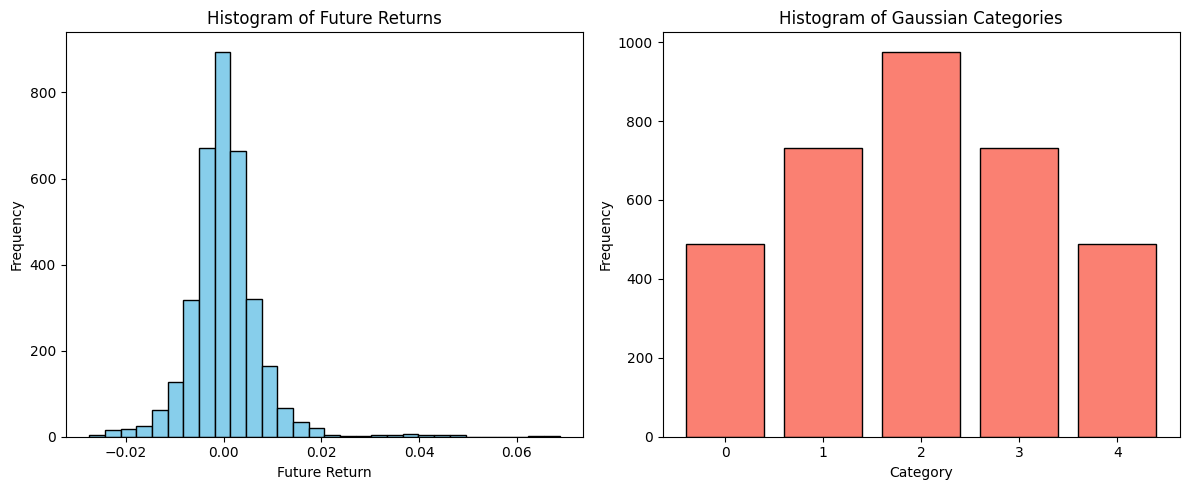

-----------------------------------------------------------------------


In [35]:
# @title
lookback = 100
look_forward = int(lookback*0.2)
size_test_prct = 0.3
input_dim = 1
hidden_dim = [32,32]
num_layers = len(hidden_dim)
num_epochs = 50
n = 5  # number of category (odd value)
output_dim = n #car on est en crosslossentity

#-------------------------------------------------------------------------------
# Calculate category_frequencies
half = n // 2
values = np.concatenate([np.linspace(1, half, half, endpoint=False), np.linspace(half, 1, n - half)])
values /= values.sum()  # Normalisation pour que la somme = 1
category_frequencies = values

#-------------------------------------------------------------------------------

data_v1 = extend_OHLC_in_data(data_v0)
input = pd.DataFrame(data_v1["Price"])
output = generate_output_category(input, category_frequencies, look_forward)
train_test_data = pd.DataFrame({"Input_1": input["Price"],
                                "Output_1": output["Category"]
                                }).dropna()
x_train, y_train, x_test, y_test = split_data(train_test_data, lookback, size_test_prct)

#-------------------------------------------------------------------------------
#Verification

debug = False
if debug:
  print("-----------------------------------------------------------------------")
  print(data_v0.head())
  print("-----------------------------------------------------------------------")
  print(data_v1.head())
  print("-----------------------------------------------------------------------")
  print(input.head())
  print(output.head())
  print("-----------------------------------------------------------------------")
  print(x_train.shape)
  y_train_series = pd.Series(y_train.cpu().numpy())
  frequency = y_train_series.value_counts().sort_index()
  print(frequency)


print("-----------------------------------------------------------------------")
print("Train/Test Size:", len(train_test_data))
print("-----------------------------------------------------------------------")
print(train_test_data.head())
print("-----------------------------------------------------------------------")
frequency = train_test_data["Output_1"].value_counts().sort_index()
print(frequency)
print("-----------------------------------------------------------------------")
verification_output(input,output)
print("-----------------------------------------------------------------------")

---------------------------------
Epoch 1 / Loss: 1.5893 / Acc: 0.2923 / F1: 0.1322 / Precision: 0.0854 / Recall: 0.2923
Epoch 10 / Loss: 1.5673 / Acc: 0.2923 / F1: 0.1322 / Precision: 0.0854 / Recall: 0.2923
Epoch 20 / Loss: 1.5587 / Acc: 0.2962 / F1: 0.1570 / Precision: 0.1661 / Recall: 0.2962
Epoch 30 / Loss: 1.5535 / Acc: 0.3056 / F1: 0.1816 / Precision: 0.1628 / Recall: 0.3056
Epoch 40 / Loss: 1.5368 / Acc: 0.3130 / F1: 0.2055 / Precision: 0.3802 / Recall: 0.3130
Epoch 50 / Loss: 1.4788 / Acc: 0.3302 / F1: 0.2620 / Precision: 0.2569 / Recall: 0.3302
---------------------------------
Training time: 88.76803421974182
---------------------------------

📊 Résumé des métriques de classification :

            Train    Test
Accuracy   0.3207  0.2442
F1-score   0.2308  0.1336
Precision  0.2658  0.1266
Recall     0.3207  0.2442
Loss       1.5098  1.7774
---------------------------------
Accuracy = proportion de prédictions correctes sur l’ensemble des classes.
Precision = parmi les prédic

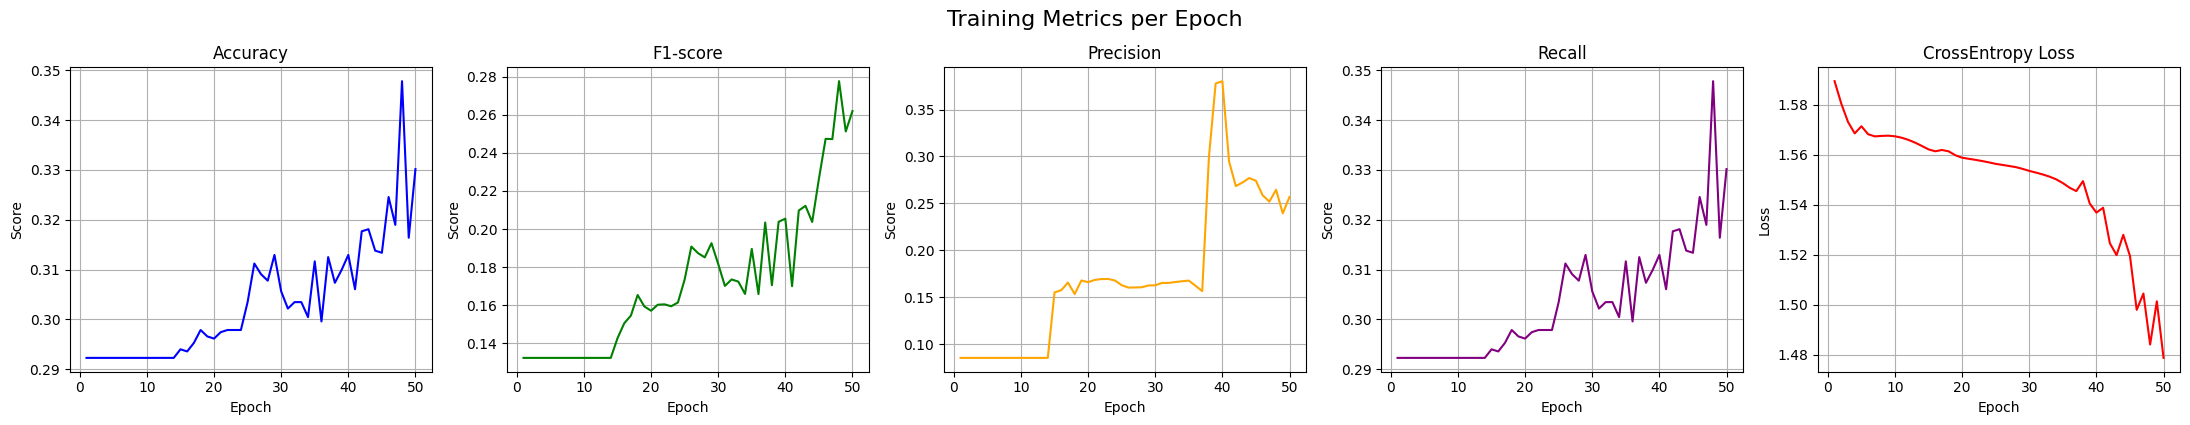

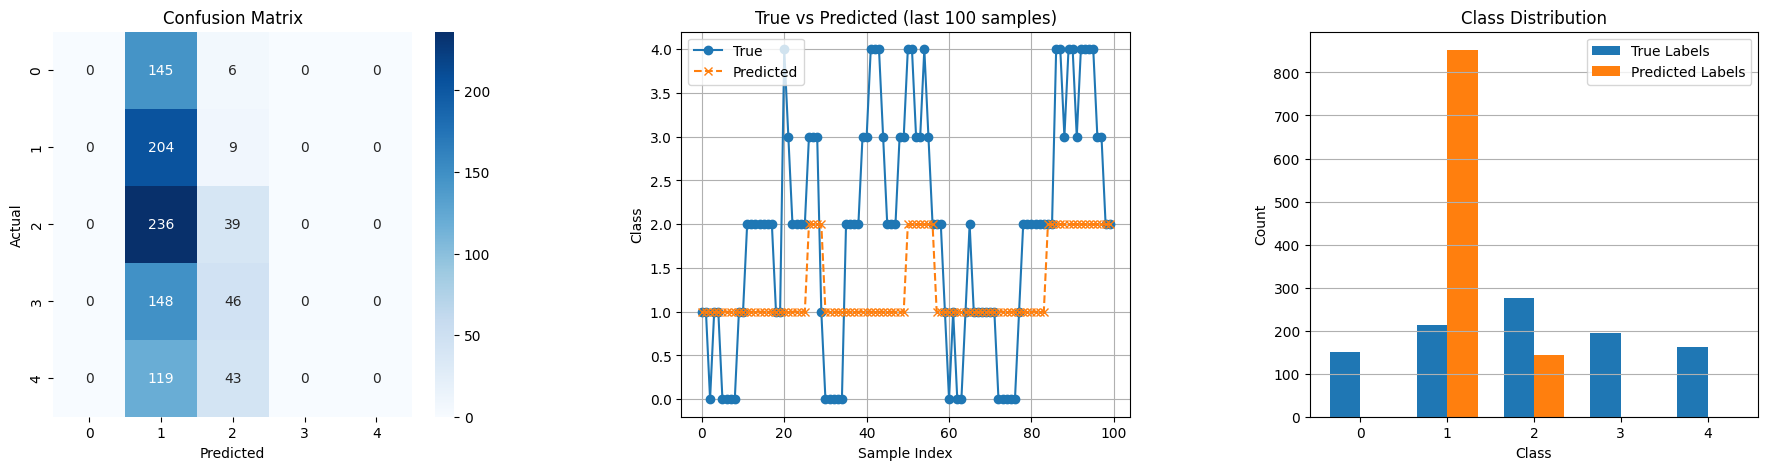

In [36]:
# Supprimer les data du train précédent
del_train_data(['model', 'optimiser', 'criterion'])

#-------------------------------------------------------------------------------
# Model Setup
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function and metric history setup
criterion, hist_criterion, hist_acc, hist_f1, hist_precision, hist_recall = metrics_setup()

print("---------------------------------")
start_time = time.time()
for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    # Compute loss and classification metrics
    loss, acc, f1, prec, rec = update_metrics(y_train_pred, y_train, criterion)

    hist_criterion[t] = loss.item()
    hist_acc[t] = acc
    hist_f1[t] = f1
    hist_precision[t] = prec
    hist_recall[t] = rec

    # Logging
    if (t+1) % 10 == 0 or t == 0:
        print(f"Epoch {t+1} / Loss: {hist_criterion[t].item():.4f} / Acc: {hist_acc[t]:.4f} / F1: {hist_f1[t]:.4f} / Precision: {hist_precision[t]:.4f} / Recall: {hist_recall[t]:.4f}")

    # Backpropagation
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("---------------------------------\nTraining time: {}\n---------------------------------".format(training_time))

#-------------------------------------------------------------------------------

model.eval()
with torch.no_grad():
    y_test_pred_list = model(x_test)                             # shape: [batch_size, n]
    y_test_pred = torch.argmax(y_test_pred_list, dim=1)          # shape: [batch_size]

#-------------------------------------------------------------------------------

# Affichage des métriques
show_final_metrics()
print("---------------------------------")
print("Accuracy = proportion de prédictions correctes sur l’ensemble des classes.")
print("Precision = parmi les prédictions positives, combien sont réellement correctes.")
print("Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.")
print("F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.")
print("Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.")
print("---------------------------------")
# Nouveau : appel à plot_metrics avec les bonnes métriques classification
plot_metrics(hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion)

visualize_classification_results(y_test, y_test_pred, output_dim, sequence_title="True vs Predicted", max_points=lookback)
#-------------------------------------------------------------------------------


📊 Résumé des métriques de classification :

            Train    Test
Accuracy   0.4832  0.3427
F1-score   0.4767  0.3004
Precision  0.4957  0.3550
Recall     0.4832  0.3427
Loss       1.1906  1.6869
---------------------------------
Accuracy = proportion de prédictions correctes sur l’ensemble des classes.
Precision = parmi les prédictions positives, combien sont réellement correctes.
Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.
F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.
Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.
---------------------------------


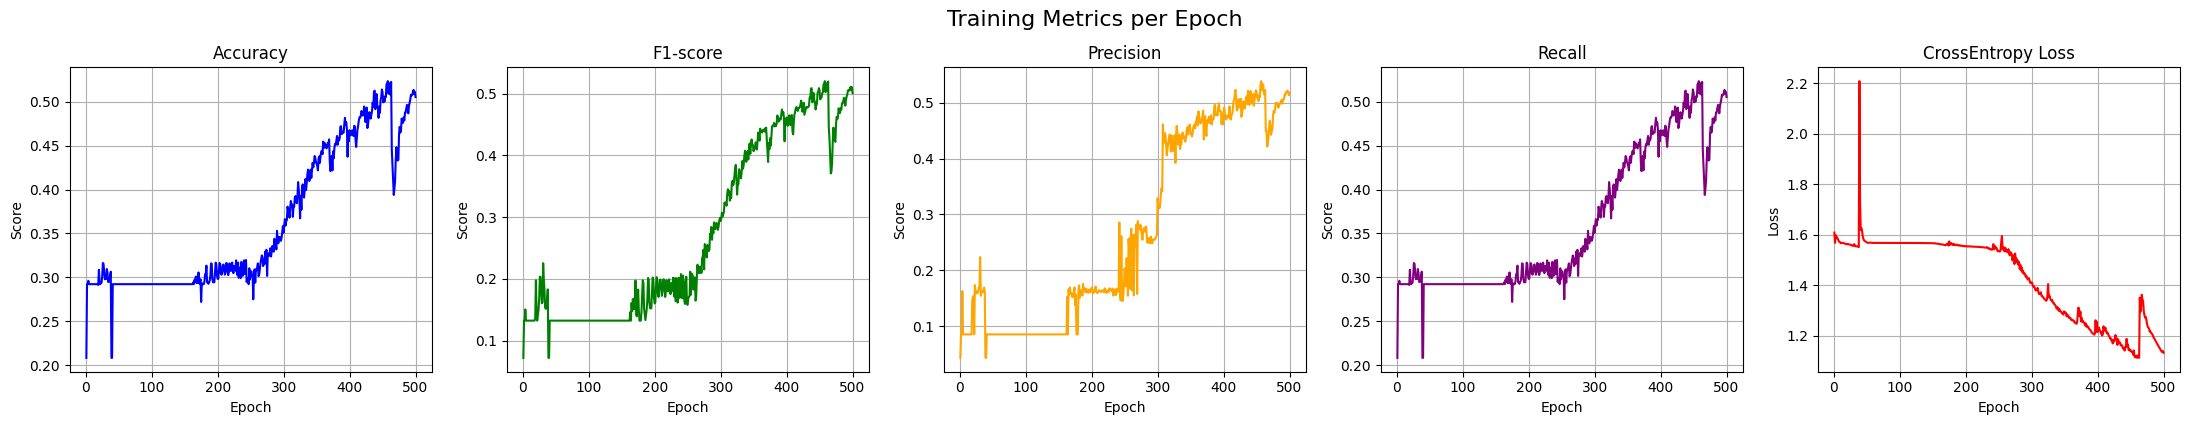

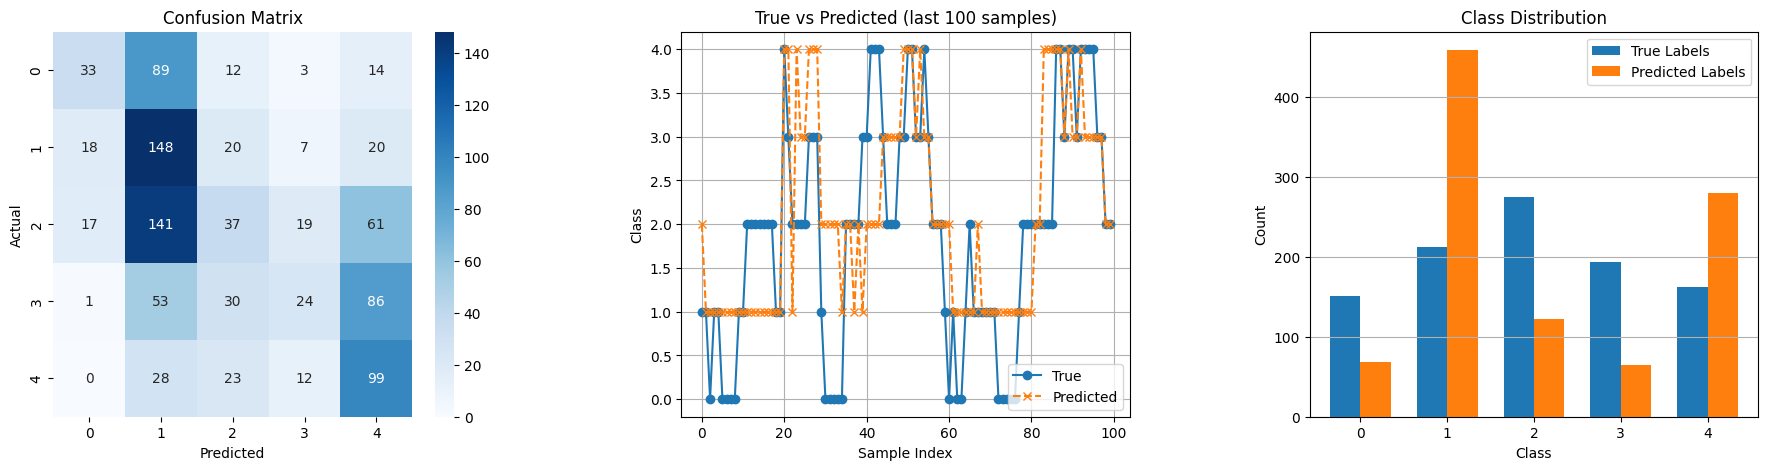

In [34]:
#-------------------------------------------------------------------------------

# Affichage des métriques
show_final_metrics()
print("---------------------------------")
print("Accuracy = proportion de prédictions correctes sur l’ensemble des classes.")
print("Precision = parmi les prédictions positives, combien sont réellement correctes.")
print("Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.")
print("F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.")
print("Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.")
print("---------------------------------")
# Nouveau : appel à plot_metrics avec les bonnes métriques classification
plot_metrics(hist_acc, hist_f1, hist_precision, hist_recall, hist_criterion)

visualize_classification_results(y_test, y_test_pred, output_dim, sequence_title="True vs Predicted", max_points=lookback)